# Assignment-2: Manifold Learning

The objective of this assignment is to apply the concepts you have learned in class on Manifold Learning and Spectral Clustering. 

## Instructions
  - For each question you need to write the sub-problem formulation in markdown. 
  - Ensure that this notebook runs without errors when the cells are run in sequence.
  - Plagiarism will not be tolerated.
  - Use only `python3` to run your code.
  - If you are facing issues running the notebook on your local system. Use google collab to run the notebook online. To run the notebook online, go to [google collab](!https://colab.research.google.com/notebooks/intro.ipynb). Go to `File  -> Upload Notebook` and import the notebook file.

__NOTE__: If you use online platforms, you will have to upload `swissroll.dat` file separately and change the path in the code cell which loads the data.

## Submission  
- Rename the notebook to `<roll_number>.ipynb` and submit **ONLY** the notebook file on moodle.

## Problems 
 - Question 1: Spectral Clustering (10 marks)
 - Question 2: Manifold Visualization (10 marks)
 - Question 3: Clustering and Visualizing high-dimensional data (10 marks)
 - Question 4: Classification (10 marks)

## Deadline 
The deadline of this assignment is 27th April, 2020, 11:59 PM

In [54]:
import sys
# Install packages correctly
!{sys.executable} -m pip install numpy sklearn tensorflow keras
# Fix mpl version due to subtle API differences
!{sys.executable} -m pip install matplotlib==3.0.3

import numpy
# Allow usage of both `np` and `numpy`
np = numpy
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_circles 
from sklearn.cluster import KMeans as km 
from sklearn import manifold, datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.svm import SVC as SVM
from sklearn.metrics import f1_score

plt.style.use('dark_background')

# Question 1: Spectral Clustering

Implement spectral clustering and evaluate on the given concentric circles dataset for this question.

## Part 1: Implementation
Implement spectral clustering function from scratch (for two clusters), taking as input the dataset. It must return the predicted clustering. Assume that the graph constructed is a fully connected graph. Use the normalized graph laplacian for this case.



In [0]:
# Part 1: Spectral Clustering
def pair_wise_distance(X, Y):
    norm_x = np.linalg.norm(X, axis = 1).reshape(-1,1)**2
    temp = np.ones((norm_x.shape[0], norm_x.shape[1]+1))
    temp[:, :-1] = norm_x
    norm_x = temp
    norm_y = np.linalg.norm(Y, axis = 1).reshape(-1,1)**2
    temp = np.ones((norm_y.shape[0], norm_y.shape[1]+1))
    temp[:, 1:] = norm_y
    norm_y = temp
    dot_p = -2*np.matmul(X, Y.T)
    d_matrix = np.matmul(norm_x, norm_y.T) + dot_p
    return d_matrix

def spectral_clustering(X):
    """Args:
      X: numpy.array [num_samples, input_dim]
      
      Returns:
      Y_pred: numpy.array [num_samples]
        array of cluster labels
    """
    # Your code here
    n = X.shape[0]
    A = pair_wise_distance(X, X)
    np.fill_diagonal(A, 0)
    W = np.exp((A)*(-0.5/(0.1*0.1)))
    np.fill_diagonal(W, 0)
    
    temp = W.sum(axis = 1)
    D = np.diag(temp)
    D_inv = np.sqrt(np.linalg.pinv(D))
    
    L = D - W
    L_norm = np.dot(D_inv, np.dot(L, D_inv))
    eig_val, eig_vec = np.linalg.eigh(L_norm)
    indices = eig_val.argsort()
    eig_val = eig_val[indices]
    eig_vec = eig_vec[:, indices]
    Y_pred = eig_vec[:, 1]

    return Y_pred


## Part 2: Clustering concentric circles
Perform spectral clustering on the concentric circles dataset. Visualize the result by plotting it on a 2-d graph. Use different colours for different clusters.

In [0]:
# DO NOT EDIT
CX, CY = make_circles(n_samples=200, shuffle=True,noise=0.05, random_state=1337, factor=0.5)
# CX: input data points [n_samples, 2]
# CY: true clusters [n_samples]

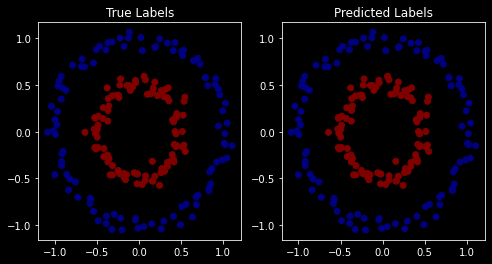

In [31]:
# Part 2: Perform Spectral Clustering on the concentric circles dataset
# Plot using colors from CY (true clusters) and CY_pred (predicted clusters)
# Code in this cell should plot 2 subplots (true labels and predicted labels)

y_pred = spectral_clustering(CX)
labels = np.zeros(y_pred.shape)
# getting our predicted labels
labels[y_pred < 0] = 1

fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot("121")
ax1.set_title("True Labels")
ax1.scatter(CX[:, 0], CX[:, 1], c = CY,cmap='jet')# labelled using true labels

ax2 = fig.add_subplot("122")
ax2.set_title("Predicted Labels")
ax2.scatter(CX[:, 0], CX[:, 1], c = labels,cmap='jet')# labelled using predicted labels

plt.show()

## Part 3: Evaluate accuracy
Evaluate the accuracy of the clustering by comparing it with the true labels. Create two subplots (true vs predicted) with the color of each point showing the cluster label.

In [9]:
# Part 3: Report the accuracy of clustering
acc = (CY == labels).sum()
print("Accuracy of clustering:", 100*acc/labels.shape[0])

Accuracy of clustering: 100.0




---



# Question 2: Manifold Visualization
Implement the various manifold learning methods and visualize the given datasets.


## Part 1: MDS
Implement Multi-Dimensional Scaling

In [0]:
# Part 1: MDS

def calc_eig_vec(D, output_dim):
    n = D.shape[0]
    temp = np.ones((n,1))
    J = np.eye(n) - (1/n)*np.dot(temp, temp.T)
    B = -0.5*(np.dot(J, np.dot(D, J)))
    eig_val, eig_vec = np.linalg.eigh(B)
    indices = eig_val.argsort()[::-1]
    eig_val = eig_val[indices]
    eig_vec = eig_vec[:, indices]
    top_p_eig_val = np.sqrt(np.diag(eig_val[:output_dim]))
    top_p_eig_vec = eig_vec[:, :output_dim]
    Y = np.dot(top_p_eig_vec, top_p_eig_val)
    return Y

def MDS(X, k, output_dim=2):
    """Args:
      X: numpy.array [n_samples, input_dim]
      k: number of nearest neighbours to construct the knn graph
      output_dim: dimension of output data

      Returns:
      Y: numpy.array [n_samples, output_dim]
    """
    n = X.shape[0]
    D = pairwise_distances(X, metric = "euclidean")
    Y = calc_eig_vec(D, output_dim)
    return Y

## Part 2: LLE
Implement Locally Linear Embedding function

In [0]:
# Part 2: LLE
def LLE(X, k, output_dim=2):
    """Args:
      X: numpy.array [n_samples, input_dim]
      k: number of nearest neighbours to construct the knn graph
      output_dim: dimension of output data

      Returns:
      Y: numpy.array [n_samples, output_dim]
    """
    KNN = sklearn.neighbors.kneighbors_graph(X, k).toarray()

    W = np.zeros(KNN.shape)
    
    for i in range(X.shape[0]):
        e = np.ones((k, 1))
        indices = np.nonzero(KNN[i])[0]
        v = X[indices,:].T #k nearest neighbors of xi
        temp = np.dot(X[i].reshape(-1, 1), e.T) - v
        gram_matrix = np.dot(temp.T, temp)
        w = np.dot(np.linalg.pinv(gram_matrix), e)
        w = w/w.sum()
        W[indices, i] = w.reshape(-1)
 
    I = np.eye(X.shape[0])
    M = np.dot((I-W), (I-W).T)
    
    eig_val, eig_vec = np.linalg.eigh(M)

    indices = eig_val.argsort()
    eig_vec = eig_vec[:, indices]

    Y = eig_vec[:, 1:output_dim+1] 
    return Y

## Part 3: ISOMAP
Implement Isomap Visualization  

In [0]:
# Part 3: Isomap
def ISOMAP(X, k, output_dim=2):
    """Args:
      X: numpy.array [n_samples, input_dim]
      k: number of nearest neighbours to construct the knn graph
      output_dim: dimension of output data

      Returns:
      Y: numpy.array [n_samples, output_dim]
    """
    # Your code here
    KNN = sklearn.neighbors.kneighbors_graph(X, k, mode = "distance")
    apsp = sklearn.utils.graph_shortest_path.graph_shortest_path(KNN, directed = False)
    apsp = apsp**2
    Y = calc_eig_vec(apsp, output_dim)
    return Y

## Part 3: Manifold Visualization
Visualize the S-shaped 3-d dataset using the MDS, ISOMAP, LLE

In [0]:
# DO NOT EDIT
SX, St = datasets.make_s_curve(n_samples=1000, random_state=1337)
# SX: input data [n_samples, 3]
# St: univariate position along manifold [n_samples], use for coloring the plots

The code in the next cell should draw a single plot with the following subplots:
1. 3D S-shaped dataset
2. 2D Manifold learnt using MDS
3. 2D Manifold learnt using ISOMAP
4. 2D Manifold learnt using LLE

Use the `St` variable to color the points in your visualizations. Use a color spectrum, and the position along the manifold to assign the color.

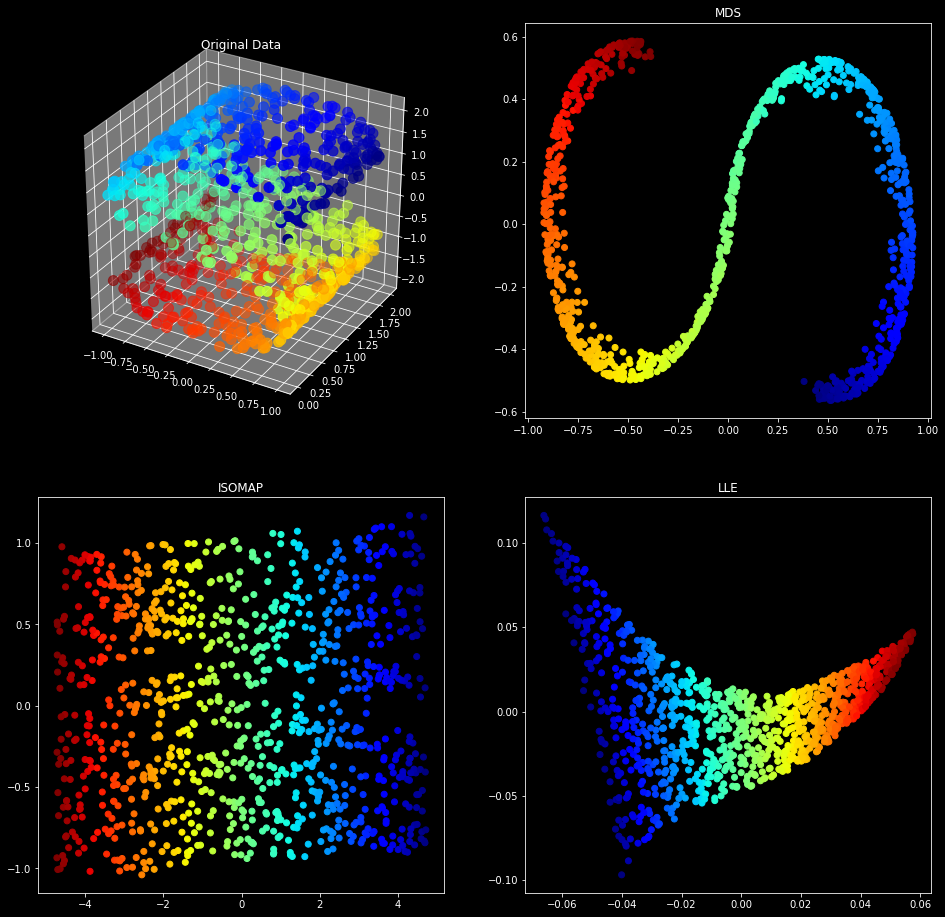

In [40]:
#  Visualization code here

fig = plt.figure(figsize = (16,16))

ax1 = fig.add_subplot("221", projection='3d')
ax1.set_title("Original Data")
ax1.scatter(SX[:,0], SX[:,1], SX[:,2], c = St, s = 100, cmap='jet')

ax2 = fig.add_subplot("222")
ax2.set_title("MDS")
y = MDS(SX, 2, 2)
ax2.scatter(y[:, 0], y[:, 1], c = St, cmap='jet')

ax3 = fig.add_subplot("223")
ax3.set_title("ISOMAP")
iso = ISOMAP(SX, 20, 2)
ax3.scatter(iso[:, 0], iso[:, 1], c = St, cmap='jet')

ax4 = fig.add_subplot("224")
ax4.set_title("LLE")
lle = LLE(SX, 20, 2)
ax4.scatter(lle[:, 0], lle[:, 1], c = St, cmap='jet')

plt.show()


# Question 3: Clustering and Visualizing high-dimensional data
Perform k-means and spectral clustering on the Swiss roll dataset and visualize using the above 3 methods. State your observations.

In [41]:
# Swiss roll dataset loading here
d = []
with open('./swissroll.dat', 'r') as dat_file:
    for line in dat_file:
        line = line.strip().split()
        line = [float(x.strip()) for x in line]
        d.append(line)
swissroll = numpy.array(d)
print (swissroll.shape)

(1600, 3)


Procedure for this question:
1. Perform spectral clustering (2 clusters) on the unchanged Swiss roll and visualize (binary colors)
2. Unwrap the manifold in 2D and visualize using
  - MDS
  - ISOMAP
  - LLE

Use the labels from the spectral clustering to color the unwrapped manifolds.

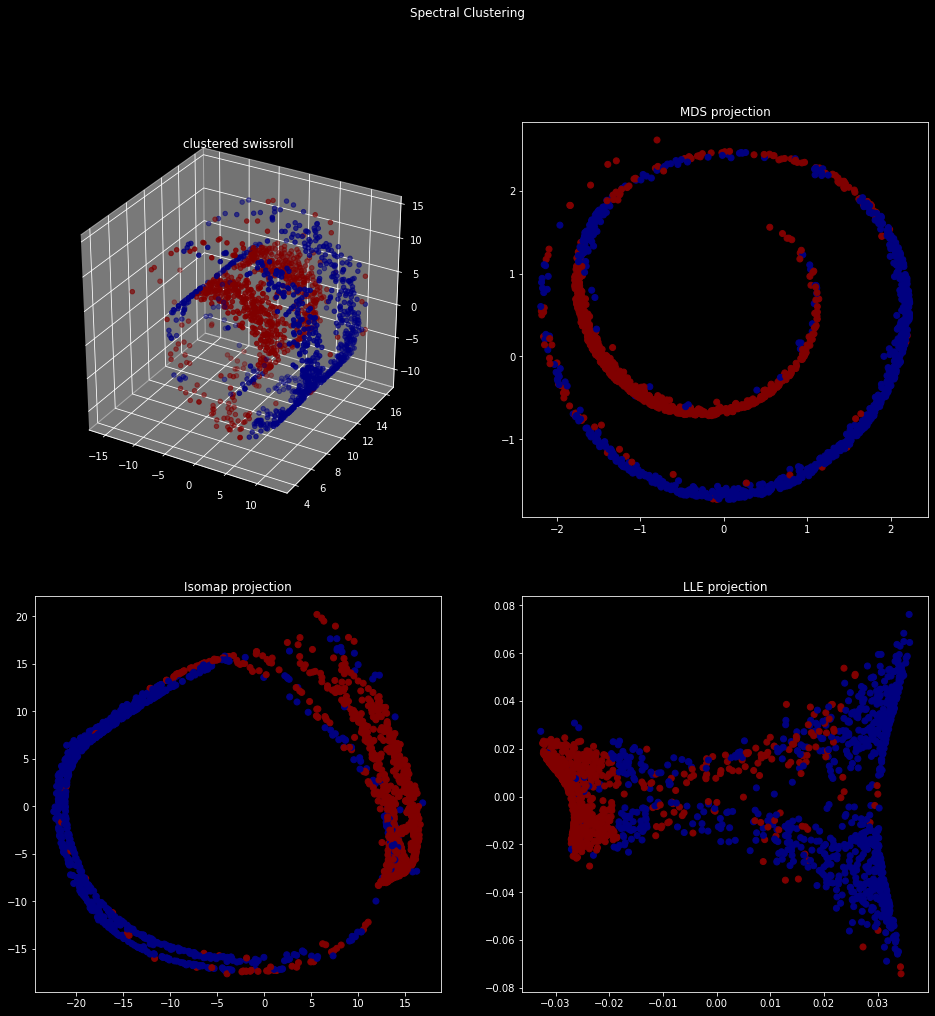

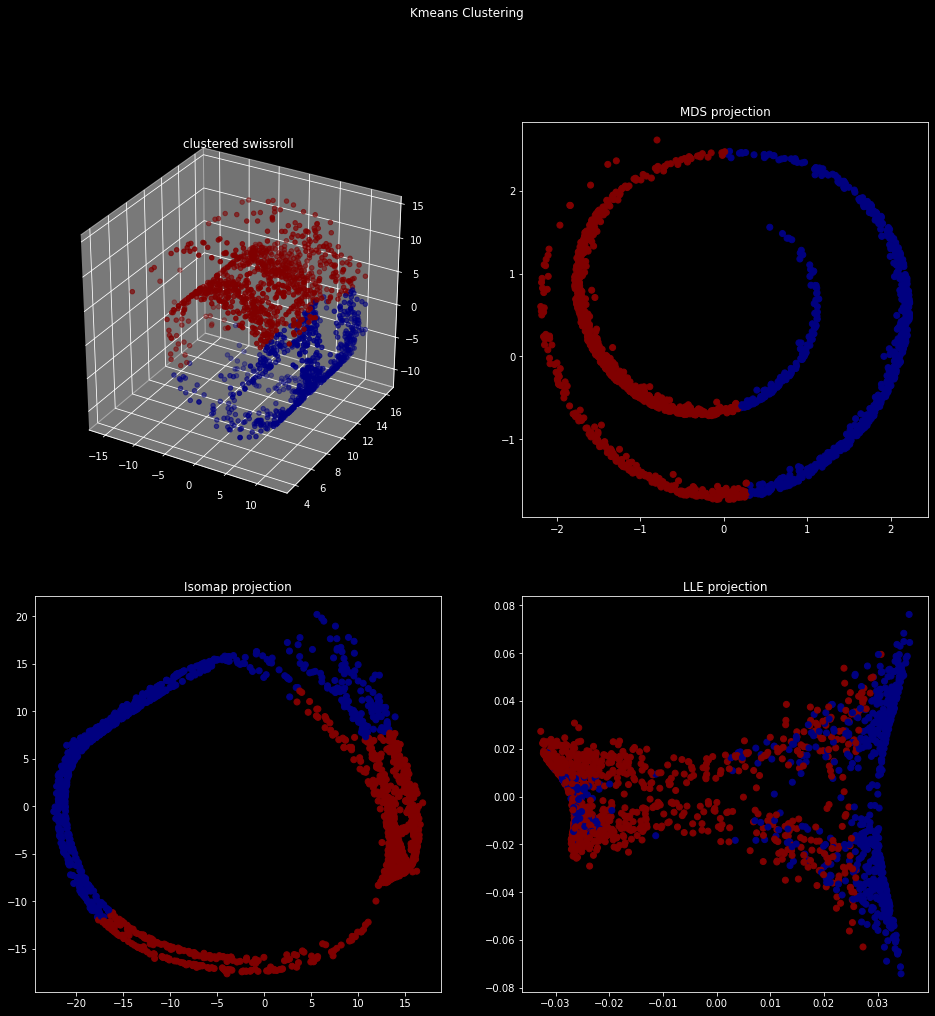

In [44]:
y_pred = spectral_clustering(swissroll)
kmeans = km(n_clusters = 2).fit(swissroll)
kmeans_labels = kmeans.labels_

labels = np.ones(swissroll.shape[0])
labels[y_pred < 0] = 0

mds = MDS(swissroll, 2, 2)
iso = ISOMAP(swissroll, 25, 2)
lle = LLE(swissroll, 25, 2)

fig = plt.figure(figsize=(16,16))
fig.suptitle("Spectral Clustering")
ax = fig.add_subplot("221", projection = "3d")
ax.set_title("clustered swissroll")
ax.scatter(swissroll[:, 0], swissroll[:, 1], swissroll[:, 2], c = labels,cmap='jet')


ax = fig.add_subplot("222")
ax.set_title("MDS projection")
ax.scatter(mds[:, 0], mds[:, 1], c = labels,cmap='jet')


ax = fig.add_subplot("223")
ax.set_title("Isomap projection")
ax.scatter(iso[:, 0], iso[:, 1], c = labels,cmap='jet')


ax = fig.add_subplot("224")
ax.set_title("LLE projection")
ax.scatter(lle[:, 0], lle[:, 1], c = labels,cmap='jet')

fig1 = plt.figure(figsize=(16,16))
fig1.suptitle("Kmeans Clustering")
ax = fig1.add_subplot("221", projection = "3d")
ax.set_title("clustered swissroll")
ax.scatter(swissroll[:, 0], swissroll[:, 1], swissroll[:, 2], c = kmeans_labels,cmap='jet')


ax = fig1.add_subplot("222")
ax.set_title("MDS projection")
ax.scatter(mds[:, 0], mds[:, 1], c = kmeans_labels,cmap='jet')


ax = fig1.add_subplot("223")
ax.set_title("Isomap projection")
ax.scatter(iso[:, 0], iso[:, 1], c = kmeans_labels,cmap='jet')


ax = fig1.add_subplot("224")
ax.set_title("LLE projection")
ax.scatter(lle[:, 0], lle[:, 1], c = kmeans_labels,cmap='jet')
plt.show()

## Observations

### Given Swissroll data has a hole in the center which induces non-convexity and makes it difficult for the manifold learning methods to unfold the data along the manifold.
I have used k = 25 for ISOMAP and LLE.

### Clustering on 3D Swissroll
- Using Kmeans clustering, gives neat results, with very less intermixing, but these are undesirable as it does not cluster along the manifold.  
- Using Spectral clustering, the datapoints are classified along the manifold, giving decent classification.
- Usage of spectral clustering to assign clusters to points leads to a bit of intermixing in case of swiss roll. This is intuitive because we cannot really cluster the points on the swiss roll visually as well.

### 2D Visualization of Swissroll Data

#### MDS

- MDS cannot unroll the swissroll properly, as no information related to manifold is incorporated during dimensionality reduction
- MDS does not do a good job in unrolling the high dimensional non-linear manifold into a linear structure.
- However, MDS gives a very good idea about the manifold in lower dimensional space. Note the obvious spiral shape of the swiss roll in 2D.

#### ISOMAP and LLE

- ISOMAP and LLE finds the hole but this distorts the unfolding of the set
- LLE and ISOMAP are capable of unfolding the the high dimensional non linear manifold into a somewhat linear structure. Hence, MDS cannot be used as a dimensionality reduction with linear classifiers.
- ISOMAP is the best algorithm of the three for use with classifiers. This is because it can create a clear separation of points without any clutter. Hence, we use this for classification in later part.
- LLE maintains local neighbourhood of points in the low dimensional space. Hence, it gives us a more interpretable visualisation as capturing relative relationship of neighbouring points well. Hoowever, ISOMAP tries to maintain overall distance the same in low dimension space rather than preserving local neighbourhood







---



# Question 4: Classification

Perform classification using a machine learning algorithm of your choice. Use 6k images from CIFAR-10 dataset.(5k images for training and 1k images for testing.)


*   Do dimensionality reduction on the dataset using PCA and ISOMAP.
*   Apply the classification algorithm.
*   Compare the results by changing the dimensionality of the data.
*   Use F1-score as metric.
*   Approach: Reduce the dimensionality into any two dimensions(of your choice) which are less than the initial dimensionality of the data using PCA and ISOMAP. Compare the performance metrics(F1-score) for the low dimensional data.



In [45]:
# Code for loading CIFAR-10 dataset.
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:5000].reshape([5000,32*32*3])
y_train = y_train[:5000]
X_test = X_test[:1000].reshape([1000,32*32*3])
y_test = y_test[:1000]
# Initial dimensionality/number of features (32*32*3) = 3072.

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


In [0]:
def reductionUsingPCA(X, k, output_dim):
    """Args:
      X: numpy.array [n_samples, input_dim]
      k: number of nearest neighbours to construct the knn graph
      output_dim: dimension of output data

      Returns:
      pca_X: numpy.array [n_samples, output_dim]
    """
    # Enter your code here
    pca_X = PCA(n_components = output_dim)
    pca_X.fit(X)
    return pca_X

In [0]:
def reductionUsingISOMAP(X, k, output_dim):
    """Args:
      X: numpy.array [n_samples, input_dim]
      k: number of nearest neighbours to construct the knn graph
      output_dim: dimension of output data

      Returns:
      isomap_X: numpy.array [n_samples, output_dim]
    """
    # Enter your code here
    embedding = Isomap(n_components=output_dim, n_neighbors = k)
    isomap_X = embedding.fit(X)
    return isomap_X

In [0]:
# Classification Algorithm 
# Extra functions here
pca_100 = reductionUsingPCA(X_train, 100, 100)
iso_100 = reductionUsingISOMAP(X_train, 100, 100)

pca_1000 = reductionUsingPCA(X_train, 100, 1000)
iso_1000 = reductionUsingISOMAP(X_train, 100, 1000)

X_train_pca_100 = pca_100.transform(X_train)
X_train_iso_100 = iso_100.transform(X_train)
X_test_iso_100 = iso_100.transform(X_test)
X_test_pca_100 = pca_100.transform(X_test)

X_train_pca_1000 = pca_1000.transform(X_train)
X_train_iso_1000 = iso_1000.transform(X_train)
X_test_iso_1000 = iso_1000.transform(X_test)
X_test_pca_1000 = pca_1000.transform(X_test)

def classification(X, n_classes,clf):
    """Args:
      X: numpy.array [n_samples, input_dim]
      n_classes: number of classes

      Returns:
      labels: numpy_array [n_samples]
    """
    # Your code here
    labels = clf.predict(X)
    return labels


In [53]:
clf1 = SVM()
clf1.fit(X_train_pca_100, y_train.reshape(-1))

clf2 = SVM()
clf2.fit(X_train_iso_100, y_train.reshape(-1))

clf3 = SVM()
clf3.fit(X_train_pca_1000, y_train.reshape(-1))

clf4 = SVM()
clf4.fit(X_train_iso_1000, y_train.reshape(-1))

y_pred_pca_100 = classification(X_test_pca_100, 10, clf1)
y_pred_iso_100 = classification(X_test_iso_100, 10, clf2)
y_pred_pca_1000 = classification(X_test_pca_1000, 10, clf3)
y_pred_iso_1000 = classification(X_test_iso_1000, 10, clf4)


def F1_score(y_true, y_pred):
    """Args:
      y_true: numpy.array [n_samples] , ground truth value
      y_pred: numpy.array [n_samples] , predicted value by classifier
      
      Returns:
      score: float, f1-score
    """
    # Enter your code here
    score = f1_score(y_true, y_pred, average = "micro")
    return score

print("F1 score for PCA(output_dim = 100):", F1_score(y_test.reshape(-1), y_pred_pca_100))
print("F1 score for Isomap(output_dim = 100):", F1_score(y_test.reshape(-1), y_pred_iso_100))
print("F1 score for PCA(output_dim = 1000):", F1_score(y_test.reshape(-1), y_pred_pca_1000))
print("F1 score for Isomap(output_dim = 1000):", F1_score(y_test.reshape(-1), y_pred_iso_1000))  

F1 score for PCA(output_dim = 100): 0.419
F1 score for Isomap(output_dim = 100): 0.354
F1 score for PCA(output_dim = 1000): 0.426
F1 score for Isomap(output_dim = 1000): 0.342


- We can see that PCA is giving better accuracies as well as F1 scores compared to Isomap for classification on the CIFAR10 dataset. This is owing to the fact that PCA is a better dimensionality reduction algorithm compared to isomap. PCA tries to minimize the reconstruction loss and hence uses directions for reductions which preserves maximum information. However, isomap is a good algorithm to visualise samples in high dimensional space.
- One should note that isomap would have done better than PCA had the images were lying on a manifold. But this is definitely not the case with the CIFAR 10 dataset.
- Increasing the number of components in PCA increases the accuracy and F1 score as more information is preserved.
- Increasing the number of components in ISOMAP decreases accuracy and F1 score a bit.